In [7]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'Task1.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
./
/content/gdrive/My Drive/Colab Notebooks/CS5228


In [8]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split



In [9]:
train = pd.read_csv('data/train_clean.csv').fillna(0)
test = pd.read_csv('data/test_clean.csv').fillna(0)

In [10]:
train.head()

,Id,make,model,manufactured,reg_date,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,price,coe_days
0,0,bmw,320i,2013.000,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",auto,1560.000,135.000,petrol,1997.000,1.000,17700.000,77100.000,1210.000,47514.000,73000.000,45330.000,50462.000,NORMAL,71300.000,835.000
1,1,toyota,hiace,2014.000,2015-01-26,van,premium ad car,manual,1740.000,111.000,diesel,2982.000,3.000,11630.000,10660.000,3545.979,3648.000,110112.000,27502.000,30502.800,NORMAL,43800.000,1249.000
2,2,mercedes-benz,cla180,2016.000,2016-07-25,luxury sedan,"parf car, premium ad car",auto,1430.000,90.000,petrol,1595.000,1.000,15070.000,53694.000,740.000,44517.000,80000.000,27886.000,31040.400,NORMAL,95500.000,1794.000
3,3,mercedes-benz,e180,2019.000,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",auto,1635.000,115.000,petrol,1497.000,1.000,16400.000,40690.000,684.000,80301.000,9800.000,46412.000,56977.000,NORMAL,197900.000,3370.000
4,4,honda,civic,2019.000,2019-09-20,mid-sized sedan,parf car,auto,1237.000,92.000,petrol,1597.000,1.000,10450.000,26667.000,742.000,36453.000,40000.000,20072.000,20101.000,NORMAL,103200.000,2947.000


In [11]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (16784, 23) 
The test data size before dropping Id feature is : (5000, 22) 

The train data size after dropping Id feature is : (16784, 22) 
The test data size after dropping Id feature is : (5000, 21) 


In [12]:
numeric = ['power','dereg_value','omv','arf']

categorical = ['make','model','reg_date','type_of_vehicle','category','transmission','fuel_type','opc_scheme']

In [13]:
# Merging train and test data for uniform pre-processing

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = all_data[['power','dereg_value','omv','arf']]
print("all_data size is : {}".format(all_data.shape))

all_data size is : (21784, 4)


## EDA and Preprocessing

###Numerical attributes -


 mu = 112919.81 and sigma = 134244.10



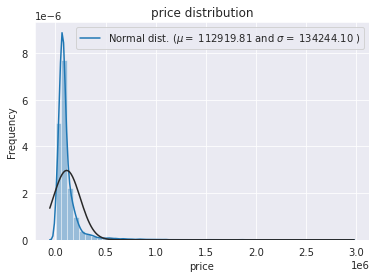

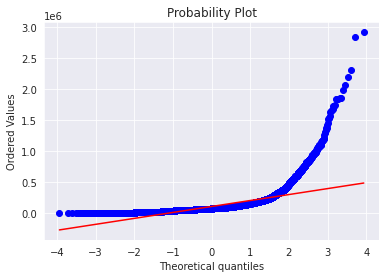

In [14]:
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()


 mu = 11.31 and sigma = 0.76



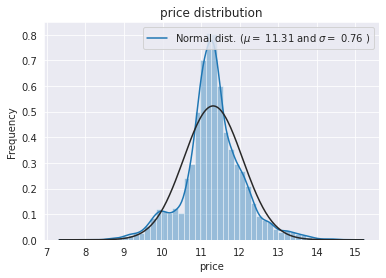

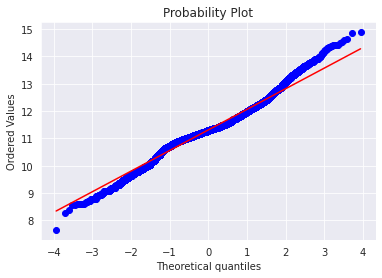

In [15]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

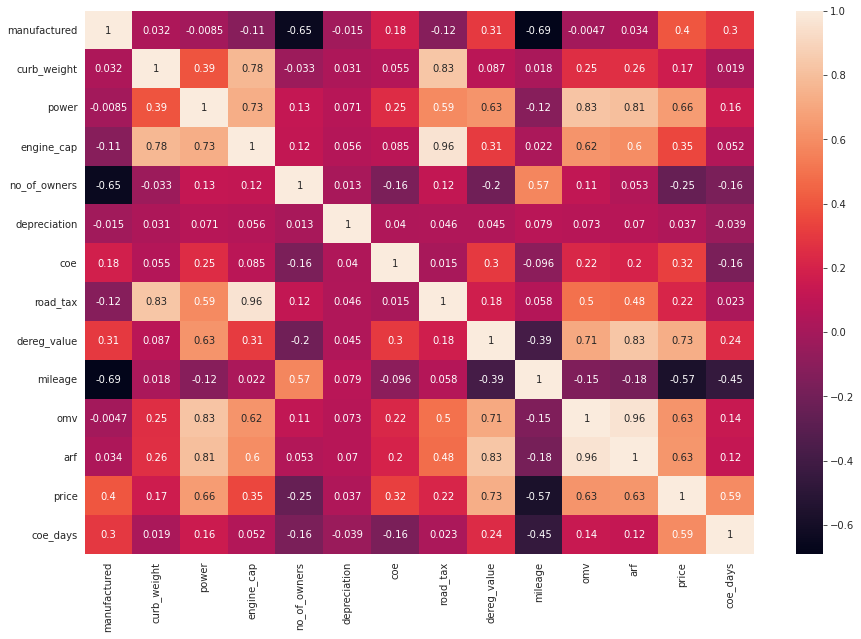

In [16]:

plt.figure(figsize = (15, 10))
sns.heatmap(train.corr(), annot = True)
plt.show()

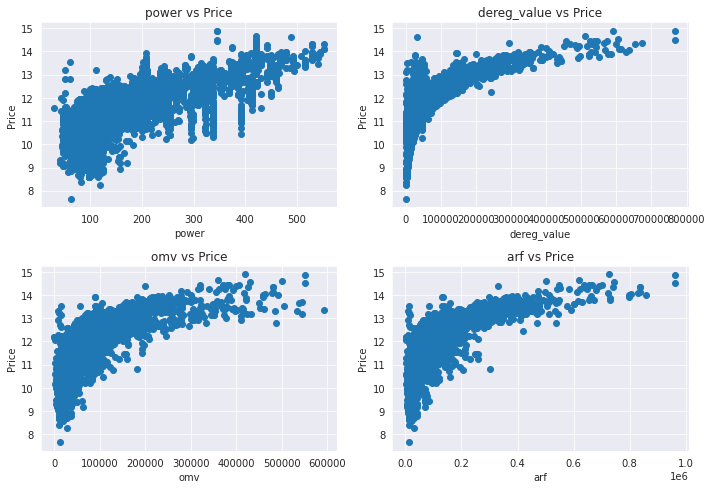

In [17]:
def scatter(x,fig):
    plt.subplot(6,2,fig)
    plt.scatter(train[x],train['price'])
    plt.title(x+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

plt.figure(figsize=(10,20))

scatter('power', 1)
scatter('dereg_value', 2)
scatter('omv', 3)
scatter('arf', 4)

plt.tight_layout()

In [19]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
arf,5.824
dereg_value,5.574
omv,5.260
power,2.378


In [20]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 4 skewed numerical features to Box Cox transform


### Categorical Attributes

In [21]:
train[categorical]

,make,model,reg_date,type_of_vehicle,category,transmission,fuel_type,opc_scheme
0,bmw,320i,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",auto,petrol,NORMAL
1,toyota,hiace,2015-01-26,van,premium ad car,manual,diesel,NORMAL
2,mercedes-benz,cla180,2016-07-25,luxury sedan,"parf car, premium ad car",auto,petrol,NORMAL
3,mercedes-benz,e180,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",auto,petrol,NORMAL
4,honda,civic,2019-09-20,mid-sized sedan,parf car,auto,petrol,NORMAL
...,...,...,...,...,...,...,...,...
16779,volvo,xc90,2016-01-22,suv,"parf car, premium ad car",auto,petrol,NORMAL
16780,hyundai,ioniq,2017-05-11,hatchback,"parf car, premium ad car, hybrid cars",auto,petrol-electric,NORMAL
16781,mini,cooper,2010-08-27,sports car,"coe car, premium ad car",auto,petrol,NORMAL
16782,honda,fit,2020-07-30,hatchback,"parf car, premium ad car",auto,petrol,NORMAL


In [22]:
train[categorical].nunique()

make                 76
model               692
reg_date           3890
type_of_vehicle      11
category            193
transmission          2
fuel_type             4
opc_scheme            3
dtype: int64

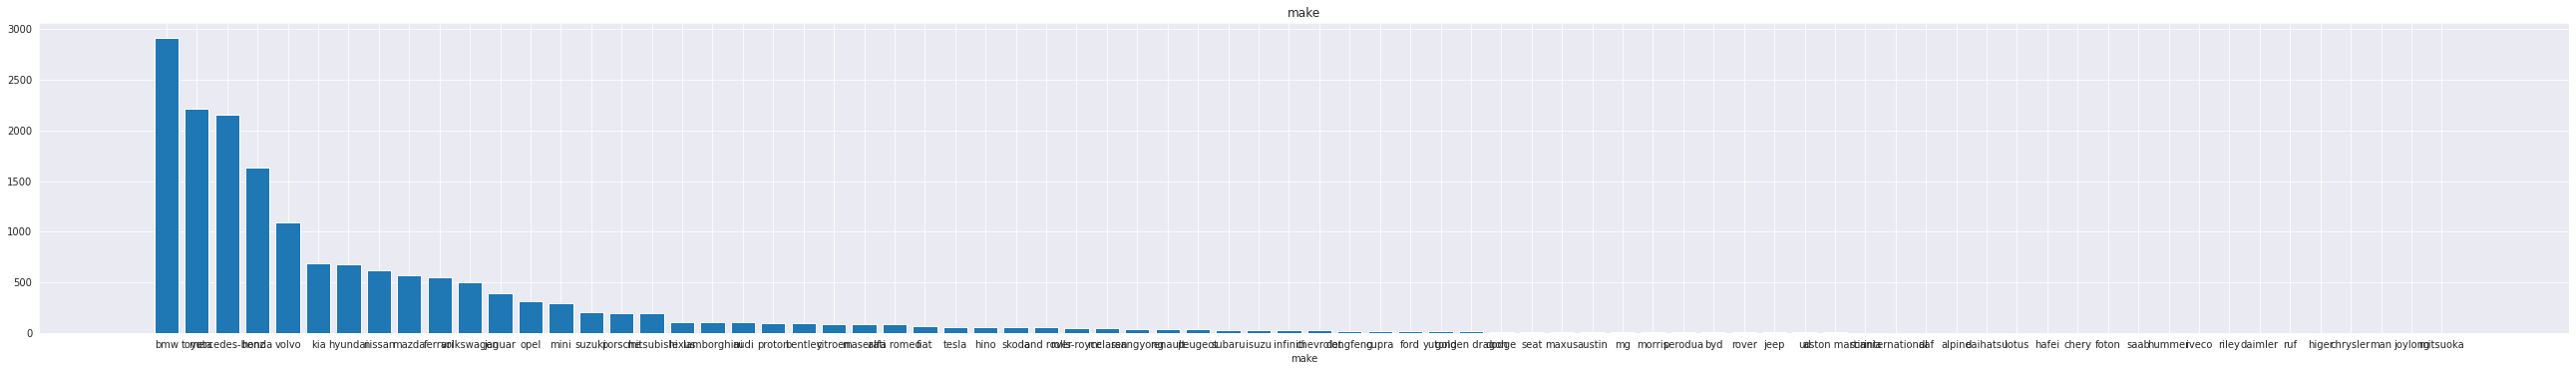

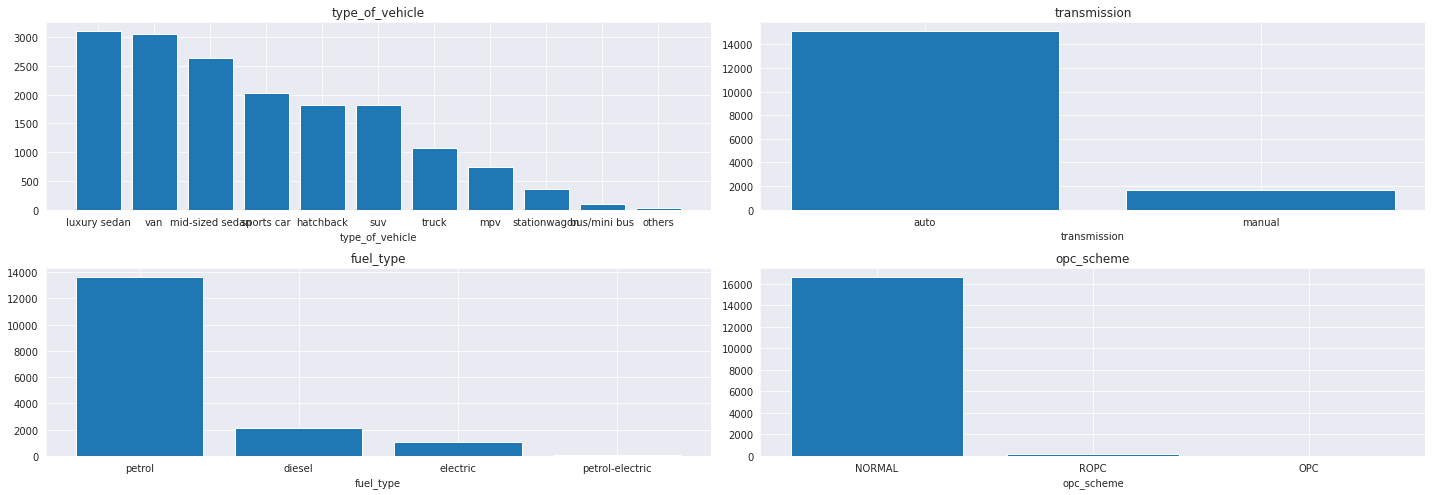

In [23]:
def hist(x,fig):
    plt.subplot(6,2,fig)
    plt.bar(train[x].unique(),train[x].value_counts())
    plt.title(x)
    plt.xlabel(x)

plt.figure(figsize=(100,40))

hist('make', 1)

plt.figure(figsize=(20,20))
hist('type_of_vehicle', 3)
hist('transmission', 4)
hist('fuel_type', 5)
hist('opc_scheme', 6)

plt.tight_layout()

In [24]:
df_dummies = pd.get_dummies(train.type_of_vehicle)

In [25]:
df_dummies = df_dummies.join(y_train)

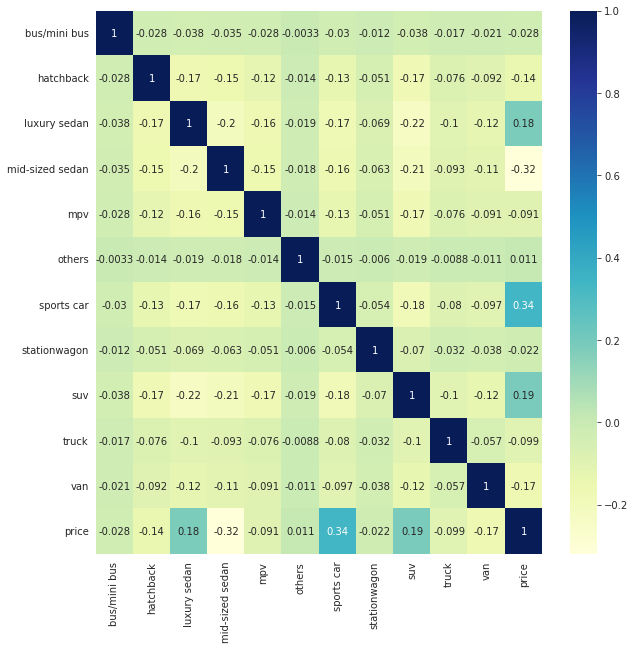

In [26]:
plt.figure(figsize = (10, 10))
sns.heatmap(df_dummies.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [27]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bus/mini bus     16784 non-null  uint8  
 1   hatchback        16784 non-null  uint8  
 2   luxury sedan     16784 non-null  uint8  
 3   mid-sized sedan  16784 non-null  uint8  
 4   mpv              16784 non-null  uint8  
 5   others           16784 non-null  uint8  
 6   sports car       16784 non-null  uint8  
 7   stationwagon     16784 non-null  uint8  
 8   suv              16784 non-null  uint8  
 9   truck            16784 non-null  uint8  
 10  van              16784 non-null  uint8  
 11  price            16784 non-null  float64
dtypes: float64(1), uint8(11)
memory usage: 311.5 KB


## Methods and Model Building

In [28]:
# Splitting the data into train and test again

X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

In [29]:


train, test, y_train, y_test = train_test_split( 
    X_train, y_train, train_size=0.7, test_size=0.3, random_state=100)

y_test = np.expm1(y_test)

In [30]:
def naive_price_predictor(X_train,y_train,X_test,y_test):
    mean=np.mean(y_train)
    prediction=mean*np.ones(y_test.shape)
    return prediction

naive_prediction=naive_price_predictor(X_train,y_train,X_test,y_test)
display(naive_prediction)

def self_defined_error_func(y_test,y_pred):
    err=np.mean(np.abs(y_test-y_pred))
    return err
naive_prediction_score=self_defined_error_func(y_test,naive_prediction)
display('The naive model gets a score of {} for the test set.'.format(naive_prediction_score))

array([11.31701534, 11.31701534, 11.31701534, ..., 11.31701534,
       11.31701534, 11.31701534])

'The naive model gets a score of 112141.04597115114 for the test set.'

In [31]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [32]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3248 (0.0151)



In [33]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.3248 (0.0151)



In [34]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.2990 (0.0022)



In [35]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.2125 (0.0086)



In [36]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.2702 (0.0026)



In [37]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.2813 (0.0029)



In [38]:
RForest = RandomForestRegressor(n_estimators=3000,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, random_state =5)

score = rmsle_cv(RForest)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 0.2726 (0.0035)



## Evaluation

In [39]:
def evaluate(y_test, pred):
  rmse = (np.sqrt(mean_squared_error(y_test, pred)))
  r2 = r2_score(y_test, pred)
  print("\nR2: ", r2)
  print("\nRMSE: ", rmse)

In [40]:
lasso.fit(train, y_train)
lasso_pred = np.expm1(lasso.predict(test.values))
evaluate(y_test, lasso_pred)


R2:  0.8411241808517335

RMSE:  53430.44909224633


In [41]:
ENet.fit(train, y_train)
ENet_pred = np.expm1(ENet.predict(test.values))
evaluate(y_test, ENet_pred)


R2:  0.8411674646859246

RMSE:  53423.17035011825


In [42]:
KRR.fit(train, y_train)
KRR_pred = np.expm1(KRR.predict(test.values))
evaluate(y_test, KRR_pred)


R2:  0.8672810296796893

RMSE:  48834.46395825738


In [43]:
GBoost.fit(train, y_train)
GBoost_pred = np.expm1(GBoost.predict(test.values))
evaluate(y_test, GBoost_pred)


R2:  0.9252857713089377

RMSE:  36640.51606179603


In [44]:
model_xgb.fit(train, y_train)
xgb_pred = np.expm1(model_xgb.predict(test))
evaluate(y_test, xgb_pred)


R2:  0.8660331495529415

RMSE:  49063.50801096866


In [45]:
model_lgb.fit(train, y_train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
evaluate(y_test, lgb_pred)


R2:  0.7864493216954319

RMSE:  61945.5910016991


In [46]:
RForest.fit(train, y_train)
RForest_pred = np.expm1(RForest.predict(test.values))
evaluate(y_test, RForest_pred)


R2:  0.8777889394620346

RMSE:  46861.39141549212
